In [2]:
import assets.utils as u

from PIL import Image
import glob
from scipy.io import savemat, loadmat
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
from matplotlib import pyplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def save_unique_pixels(scale):
    path  = "C:\\Users\\ustundag\\Github\\2D-3D-Semantics\\area_3\\data\\semantic_pretty\\camera*.png"
    paths = glob.glob(path)
    pixel_collection = np.ndarray(shape=(0,3), dtype=int)
    file = "noXYZ_area_3_no_xyz_data_semantic_pretty_pixel_collection_scale_" + str(scale) + ".mat"
    i = 0
    for p in paths:
        clear_output(wait=True)
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # open-cv returns in BGR format
        img = img[::scale, ::scale] # The more scale down, the less number of unique pixels! 
        pixels = np.unique(img.reshape(img.shape[0]*img.shape[1], img.shape[2]), axis=0)
        #pixels = set( tuple(v) for m2d in img for v in m2d )
        pixel_collection = np.append(pixel_collection, pixels, axis=0)
        #pixel_collection = np.concatenate((pixel_collection, pixels), axis=0)
        #pixel_collection = np.vstack((pixel_collection, pixels))
        i += 1
        display(str(i) + " / 3704")
    
    savemat(file, {'pixel_collection': np.array(pixel_collection)})

In [4]:
# Function to map int labels to object classes
def assign_label(object):
    switcher = {
        'board':    0,
        'bookcase': 1,
        'chair':    2,
        'door':     3,
        'sofa':     4,
        'table':    5,
        'window':   6,
        '<UNK>':    7,
        'wall':     8,
        'beam':     9,
        'ceiling':  10,
        'clutter':  11,
        'column':   12,
        'floor':    13
    }

    return switcher.get(object, 14)

In [5]:
def save_labels(pixel_collection, scale):
    labels = u.load_labels('C:/Users/ustundag/Github/2D-3D-Semantics/assets/semantic_labels.json')
    limit = int(len(labels))
    file = "noXYZ_area_3_no_xyz_data_semantic_pretty_pixel_labels_scale_" + str(scale) + ".mat"
    labels_gt = []
    
    for p in pixel_collection:
        i = u.get_index(p)
        if type(i) == 'str': print('str i detected: ' + str(i))
        if i < limit:
            instance_label = labels[i]
            instance_label_as_dict = u.parse_label(instance_label)
            label = assign_label(instance_label_as_dict["instance_class"])
            labels_gt.append(label)
        else:
            labels_gt.append(14) # newly added in case index is out of bounds in "labels.json" file

    savemat(file, {'labels_gt': np.array(labels_gt)})

In [6]:
save_unique_pixels(scale=4)
pixels = loadmat("C:\\Users\\ustundag\\Github\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_semantic_pretty_pixel_collection_scale_4.mat")
pixels = pixels["pixel_collection"]
print(pixels.shape)

'3704 / 3704'

(79413, 3)


### Visualize pixel collection in 3D

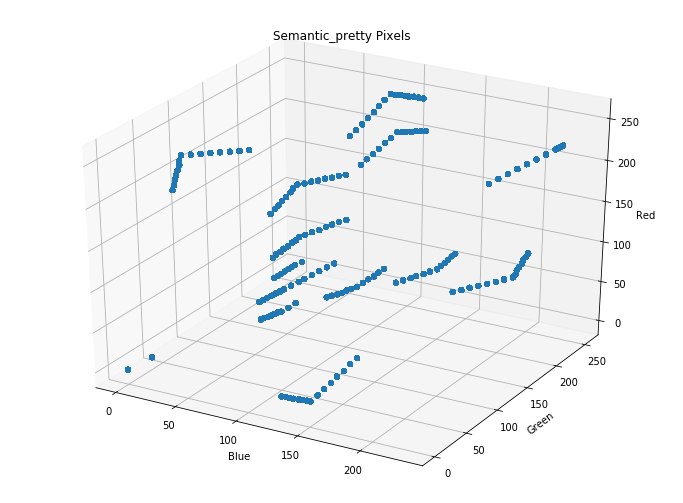

In [10]:
r, g, b = pixels[:,0], pixels[:,1], pixels[:,2]

fig = plt.figure(1, figsize=(12, 9))
axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis
axis.scatter(b, g, r, marker='o')
axis.set_xlabel("Blue")
axis.set_ylabel("Green")
axis.set_zlabel("Red")
axis.set_title("Semantic_pretty Pixels")
pyplot.show()

### RGB2HSV Conversion

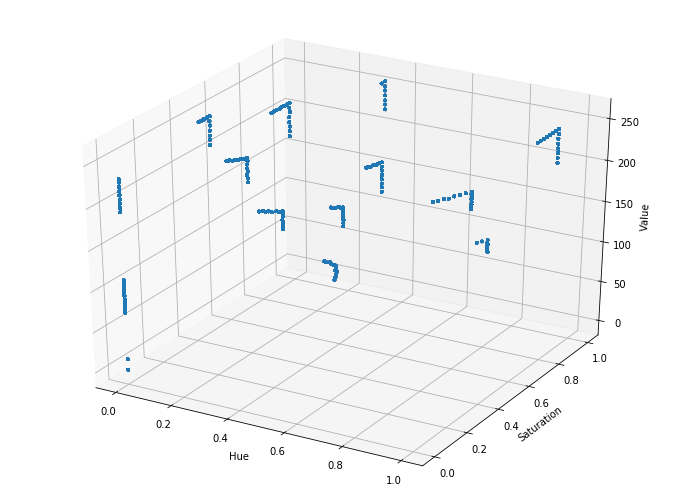

In [13]:
from matplotlib.colors import rgb_to_hsv

hsv_pix = rgb_to_hsv(pixels)
h, s, v = hsv_pix[:,0], hsv_pix[:,1], hsv_pix[:,2]

fig = plt.figure(1, figsize=(12, 9))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), marker='.')
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

### KMeans
Determining the best number of clusters; So, 3 is the elbow point for cluster numbers. Maybe 6 or even 7?

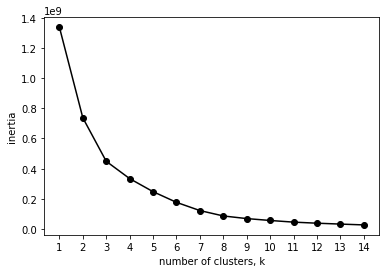

In [14]:
from sklearn.cluster import KMeans

ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters and fit model
    model = KMeans(n_clusters=k).fit(pixels)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

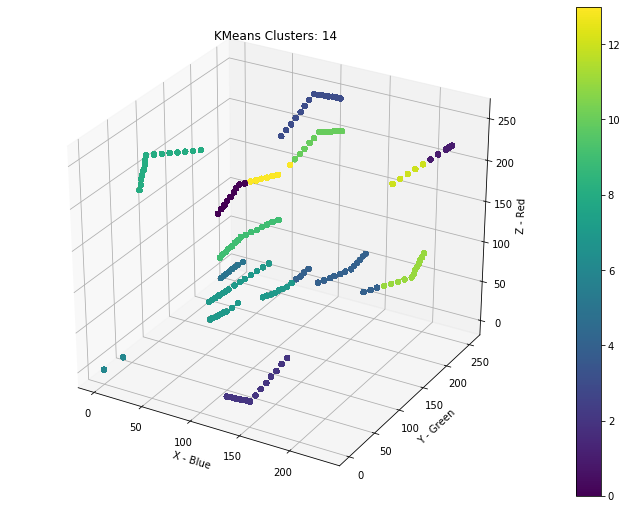

In [17]:
# Apply kmeans and plot 3D
# Datset has 7 unique object classes in general
n_clusters = 14
kmeans = KMeans(n_clusters).fit(pixels)
labels_kmeans = kmeans.labels_

r, g, b = pixels[:,0], pixels[:,1], pixels[:,2]

fig = plt.figure(1, figsize=(12, 9))
ax  = fig.add_subplot(111, projection='3d')
axs = ax.scatter(b, g, r, c=labels_kmeans.astype(np.float))

fig.colorbar(axs)
ax.set_xlabel('X - Blue')
ax.set_ylabel('Y - Green')
ax.set_zlabel('Z - Red')
ax.set_title("KMeans Clusters: " + str(n_clusters))
ax.dist = 10
plt.show()

### DBSCAN
Apply DBSCAN and plot 3D.

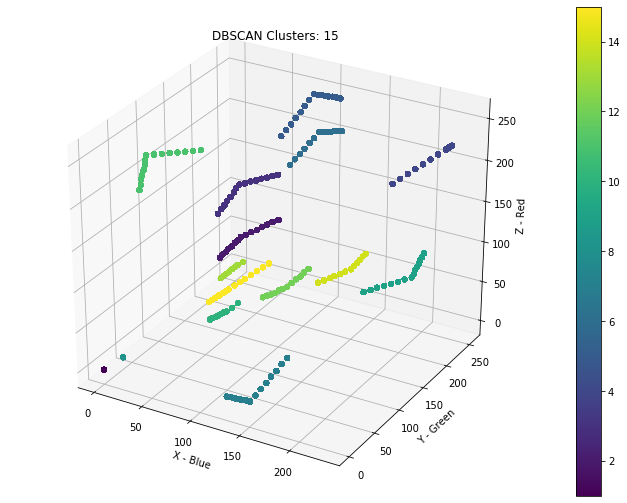

In [28]:
from sklearn.cluster import DBSCAN

r, g, b = pixels[:,0], pixels[:,1], pixels[:,2]

dbs = DBSCAN(eps = 14, min_samples = 300)
labels_dbscan = dbs.fit_predict(pixels)+1

fig = plt.figure(1, figsize=(12, 9))
ax  = fig.add_subplot(111, projection='3d')
axs = ax.scatter(b, g, r, c=labels_dbscan.astype(np.float))

fig.colorbar(axs)
ax.set_xlabel('X - Blue')
ax.set_ylabel('Y - Green')
ax.set_zlabel('Z - Red')
ax.set_title("DBSCAN Clusters: " + str(len(set(labels_dbscan))))
ax.dist = 10
plt.show()

### HDBSCAN

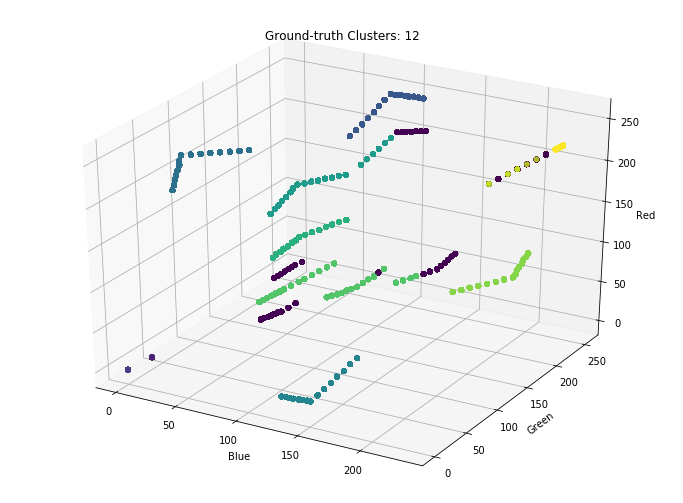

12


In [38]:
from hdbscan import HDBSCAN

hdb = HDBSCAN(algorithm='best', alpha=1.0, min_cluster_size=1800).fit(pixels)
hdb_labels = hdb.labels_
"""
import hdbscan
hdb = hdbscan.RobustSingleLinkage(cut=5, k=100)
hdb_labels = hdb.fit_predict(pixels)
"""
fig = plt.figure(1, figsize=(12, 9))
axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis
axis.scatter(b, g, r, c = hdb_labels)
axis.set_xlabel("Blue")
axis.set_ylabel("Green")
axis.set_zlabel("Red")
axis.set_title("Ground-truth Clusters: " + str(len(set(hdb_labels))))
pyplot.show()
print(str(len(set(hdb_labels))))

### MeanShift

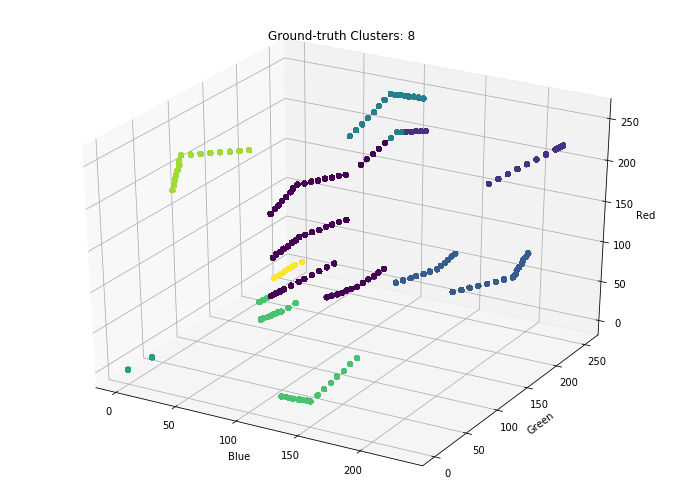

In [41]:
from sklearn.cluster import MeanShift, estimate_bandwidth

r, g, b = pixels[:,0], pixels[:,1], pixels[:,2]

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(pixels, quantile=0.2, n_samples=50)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pixels)
labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_

fig = plt.figure(1, figsize=(12, 9))
axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis
axis.scatter(b, g, r, c = labels_ms)
axis.set_xlabel("Blue")
axis.set_ylabel("Green")
axis.set_zlabel("Red")
axis.set_title("Ground-truth Clusters: " + str(len(set(labels_ms))))
pyplot.show()

In [ ]:
# MeanShift cluster size analysis
"""
for quantile in np.arange(0.2, 0.5, 0.01):
    for n_samples in range(10,20):
        bandwidth = estimate_bandwidth(pixels, quantile = quantile, n_samples = n_samples)
        #print("bandwidth: " + str(bandwidth))
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(pixels)
        labels_ms = ms.labels_
        cluster_centers = ms.cluster_centers_
        if 10 < len(set(labels_ms)) < 20:
            print("#Clusters: " + str(len(set(labels_ms))) +
                  " - quantile: " + str(quantile) +
                  " - n_samples: " + str(n_samples) +
                  " - Score: " + str(normalized_mutual_info_score(labels_gt, labels_ms)))

print("finished!")
"""